In [19]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import sys

# Add the project directory to sys.path
project_dir = Path.cwd().parent  # Adjust as needed to point to your project root
sys.path.append(str(project_dir))

print("project_dir: ", project_dir)
from utils.pipeline import Pipeline, EvaluationEnum

dataloader = Pipeline(evaluation=EvaluationEnum.LAST)



data, target = dataloader.get_security_classification_dataset_and_target()

vars2drop=['PD_CD', 'KY_CD', 'OFNS_DESC', 'LAW_CAT_CD', 'ARREST_BORO', 'AGE_GROUP', 'PERP_SEX', 'PERP_RACE', 'Latitude', 'Longitude', 'YEAR', 'MONTH', 'DAY_OF_WEEK', 'IS_WEEKEND', 'DAY_OF_YEAR_sin', 'DAY_OF_YEAR_cos']

data = data.drop(columns=vars2drop)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
project_dir:  /Users/hugojarudd/Desktop/kdd-process/src


In [20]:
from numpy import array, ndarray
from sklearn.model_selection import train_test_split
from pandas import DataFrame, Series, Index, Period

file_tag = "CLASS__security"
target = "CLASS__security"
eval_metric = "f1"

train, test = train_test_split(data, test_size=0.2, random_state=42)

labels: list = list(train[target].unique())
labels.sort()

trnY: array = train.pop(target).to_list()
trnX: ndarray = train.values

tstY: array = test.pop(target).to_list()
tstX: ndarray = test.values

Train#=4163 Test#=1041
Labels=[np.int64(0), np.int64(1)]
KNN best with k=17 and manhattan


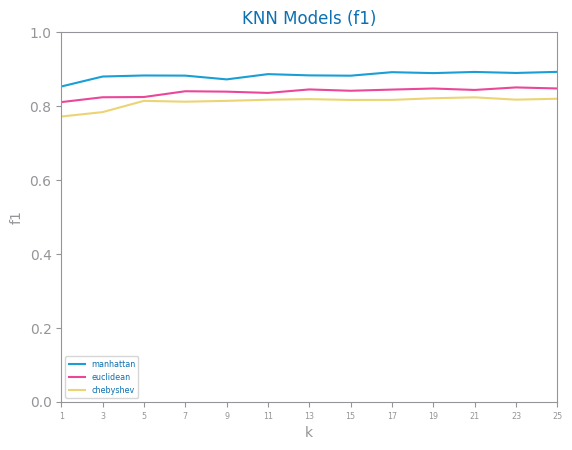

In [21]:
from typing import Literal
from numpy import array, ndarray
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.pyplot import figure, savefig, show
from dslabs_functions import CLASS_EVAL_METRICS, DELTA_IMPROVE, plot_multiline_chart
from dslabs_functions import read_train_test_from_files, plot_evaluation_results

def knn_study(
        trnX: ndarray, trnY: array, tstX: ndarray, tstY: array, k_max: int=19, lag: int=2, metric='accuracy'
        ) -> tuple[KNeighborsClassifier | None, dict]:
    dist: list[Literal['manhattan', 'euclidean', 'chebyshev']] = ['manhattan', 'euclidean', 'chebyshev']

    kvalues: list[int] = [i for i in range(1, k_max+1, lag)]
    best_model: KNeighborsClassifier | None = None
    best_params: dict = {'name': 'KNN', 'metric': metric, 'params': ()}
    best_performance: float = 0.0

    values: dict[str, list] = {}
    for d in dist:
        y_tst_values: list = []
        for k in kvalues:
            clf = KNeighborsClassifier(n_neighbors=k, metric=d)
            clf.fit(trnX, trnY)
            prdY: array = clf.predict(tstX)
            eval: float = CLASS_EVAL_METRICS[metric](tstY, prdY)
            y_tst_values.append(eval)
            if eval - best_performance > DELTA_IMPROVE:
                best_performance: float = eval
                best_params['params'] = (k, d)
                best_model = clf
            # print(f'KNN {d} k={k}')
        values[d] = y_tst_values
    print(f'KNN best with k={best_params["params"][0]} and {best_params["params"][1]}')
    plot_multiline_chart(kvalues, values, title=f'KNN Models ({metric})', xlabel='k', ylabel=metric, percentage=True)

    return best_model, best_params

file_tag = 'stroke'
target = 'stroke'
eval_metric = 'f1'

print(f'Train#={len(trnX)} Test#={len(tstX)}')
print(f'Labels={labels}')

figure()
best_model, params = knn_study(trnX, trnY, tstX, tstY, k_max=25, metric=eval_metric)
#savefig(f'images/{file_tag}_knn_{eval_metric}_study.png')
show()

<Figure size 640x480 with 0 Axes>

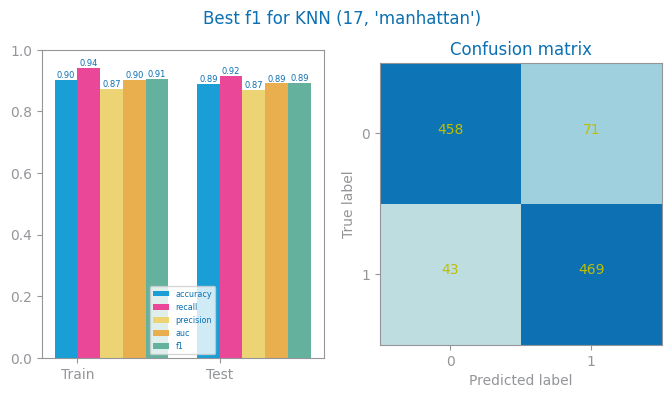

In [22]:
prd_trn: array = best_model.predict(trnX)
prd_tst: array = best_model.predict(tstX)
figure()
plot_evaluation_results(params, trnY, prd_trn, tstY, prd_tst, labels)
#savefig(f'images/{file_tag}_knn_{params["name"]}_best_{params["metric"]}_eval.png')
show()

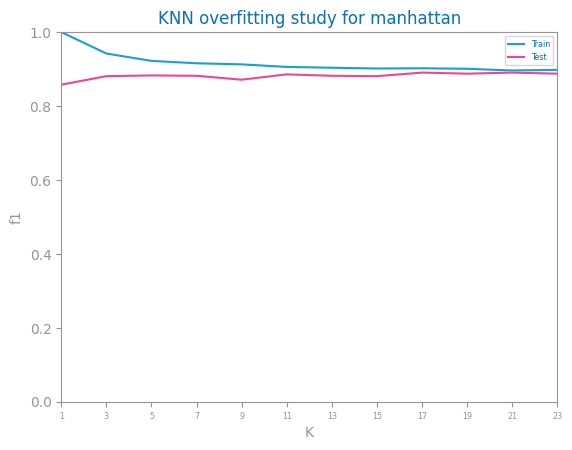

In [23]:
from matplotlib.pyplot import figure, savefig

distance: Literal["manhattan", "euclidean", "chebyshev"] = params["params"][1]
K_MAX = 25
kvalues: list[int] = [i for i in range(1, K_MAX, 2)]
y_tst_values: list = []
y_trn_values: list = []
acc_metric: str = "accuracy"
for k in kvalues:
    clf = KNeighborsClassifier(n_neighbors=k, metric=distance)
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[acc_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[acc_metric](trnY, prd_trn_Y))

figure()
plot_multiline_chart(
    kvalues,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"KNN overfitting study for {distance}",
    xlabel="K",
    ylabel=str(eval_metric),
    percentage=True,
)
#savefig(f"images/{file_tag}_knn_overfitting.png")
show()